In [282]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [283]:
# Load the data
representatives_df = pd.read_excel('Data/Representatives.xlsx')

csv_folder = os.path.join(os.getcwd(), "csv_outputs")
json_folder = os.path.join(os.getcwd(), "json_outputs")

In [284]:
print("Columns:", representatives_df.columns.tolist())

Columns: ['REP_CODE', 'REP_DESC', 'COMM_METHOD', 'COMMISSION']


In [285]:
print("Sample data:\n", representatives_df.head())

Sample data:
   REP_CODE                  REP_DESC COMM_METHOD  COMMISSION
0        0                   Unknown     Unknown         0.0
1       01               HEAD OFFICE       Sales         0.0
2      010                BA ALLISON       Sales         0.5
3     010C  BA CONSIGNMENT SALES ACC       Sales         0.5
4    01AME            01 CREDIT CARD       Sales         0.5


In [286]:
print("Null values:\n", representatives_df.isnull().sum())

Null values:
 REP_CODE       0
REP_DESC       0
COMM_METHOD    0
COMMISSION     0
dtype: int64


In [287]:
# Remove rows with any null values
representatives_df = representatives_df.dropna()

In [288]:
print("Data shape:", representatives_df.shape)

Data shape: (128, 4)


In [289]:
representatives_df

,REP_CODE,REP_DESC,COMM_METHOD,COMMISSION
0,0,Unknown,Unknown,0.0
1,01,HEAD OFFICE,Sales,0.0
2,010,BA ALLISON,Sales,0.5
3,010C,BA CONSIGNMENT SALES ACC,Sales,0.5
4,01AME,01 CREDIT CARD,Sales,0.5
...,...,...,...,...
123,ZZZ3,BAD DEBTS-DUCHESS-HANDED OVER,Gross Profit,0.0
124,ZZZ4,BAD CREDIT,Sales,0.0
125,ZZZ5,CLOSED,Sales,0.0
126,ZZZ6,BLOCK AND MOVE - DO NOT USE,Gross Profit,0.0


In [290]:

# Strip whitespace and list unique REP_DESC values
unique_rep_desc = representatives_df['REP_DESC'].astype(str).str.strip().unique()

# Display as a sorted DataFrame for inspection
pd.DataFrame({'REP_DESC': sorted(unique_rep_desc)})

,REP_DESC
0,01 CREDIT CARD
1,01 N
2,07-GROUP-LA
3,BA ALLISON
4,BA CONSIGNMENT SALES ACC
...,...
114,VP
115,WHOLESALERS
116,discount specials
117,do not use


### Cleaning and Validating Representative Descriptions (`REP_DESC`)

This step standardizes and renames ambiguous or system-generated descriptions. We also validate which entries belong in the `dim_representative` table.

- **Valid entries** include real agents and recognized sales channels (e.g., consignment, catalogue).
- **Excluded entries** include placeholders, internal routing, discounts, and financial exceptions.

This ensures that only meaningful, joinable entities are retained in the dimension table.

In [291]:
rep_desc_map = {
    # Placeholder or system-generated
    'UNKNOWN': 'UNASSIGNED',  # No rep assigned; drop

    # Internal routing or admin logic
    'HEAD OFFICE': 'NON-AGENT: HEAD OFFICE',  # Admin unit; drop
    'HEAD OFFICE DO NOT USE': 'NON-AGENT: HEAD OFFICE',  # Same
    "HEAD OFFICE'S CUSTOMER DEPT STORE": 'NON-AGENT: HEAD OFFICE',
    'HEAD OFFICE-TOP TEN DEPT STORES': 'NON-AGENT: HEAD OFFICE',

    # Valid agents or agent groups
    'BA ALLISON': 'AGENT: BA ALLISON',
    'JU': 'AGENT: JU',
    'LL': 'AGENT: LL',
    'EM': 'AGENT: EM',
    'VP': 'AGENT: VP',
    'RL': 'AGENT: RL',
    'BM': 'AGENT: BM',
    'BJ': 'AGENT: BJ',
    'DA': 'AGENT: DA',
    'LA': 'AGENT: LA',
    'CM': 'AGENT: CM',
    'CH': 'AGENT: CH',
    'DR': 'AGENT: DR',
    'GR': 'AGENT: GR',
    'ML': 'AGENT: ML',
    'SH': 'AGENT: SH',

    # Valid sales channels
    '01 CREDIT CARD': 'CHANNEL: CREDIT CARD',
    'CATALOGUE CUSTOMER ONLY - BJ': 'CHANNEL: CATALOGUE - BJ',
    'CATALOGUE CUSTOMER ONLY - BM': 'CHANNEL: CATALOGUE - BM',
    'CATALOGUE CUSTOMER ONLY - RO': 'CHANNEL: CATALOGUE - RO',
    'CATALOGUE CUSTOMER-CH': 'CHANNEL: CATALOGUE - CH',
    'CONSIGNMENTS BJ': 'CHANNEL: CONSIGNMENT - BJ',
    'CONSIGNMENTS BM': 'CHANNEL: CONSIGNMENT - BM',
    'CONSIGNMENTS HO': 'CHANNEL: CONSIGNMENT - HO',
    'CONSIGNMENTS DA': 'CHANNEL: CONSIGNMENT - DA',
    'CONSIGNMENTS LA': 'CHANNEL: CONSIGNMENT - LA',
    'CONSIGNMENTS DE': 'CHANNEL: CONSIGNMENT - DE',
    'CONSIGNMENT BA': 'CHANNEL: CONSIGNMENT - BA',
    'CONSIGNMENT DE/STAND': 'CHANNEL: CONSIGNMENT - DE',
    'CONSIGNMENT BJ/STAND': 'CHANNEL: CONSIGNMENT - BJ',
    'CONSIGNMENT BM/STAND': 'CHANNEL: CONSIGNMENT - BM',
    'CONSIGNMENT HO/STAND': 'CHANNEL: CONSIGNMENT - HO',
    'CONSIGNMENT DA/STAND': 'CHANNEL: CONSIGNMENT - DA',
    'CONSIGNMENT LA / STAND': 'CHANNEL: CONSIGNMENT - LA',

    # Invalid or unusable
    'FAULTY CODE - DO NOT USE': 'INVALID CODE',
    'DO NOT USE': 'INVALID CODE',
    'BLOCK AND MOVE - DO NOT USE': 'INVALID CODE',

    # Financial exceptions
    'BAD DEBT- H/OVER': 'NON-AGENT: BAD DEBT',
    'BAD DEBTS-DUCHESS-HANDED OVER': 'NON-AGENT: BAD DEBT',
    'BAD CREDIT': 'NON-AGENT: BAD CREDIT',
    'CLOSED': 'NON-AGENT: CLOSED ACCOUNT',
    'PROBLEM - DECEASED ESTATES': 'NON-AGENT: DECEASED ESTATE',
    'PROBLEM - INSOLVENT ACCOUNT': 'NON-AGENT: INSOLVENT',
    'PROBLEM-BAD DEBT-PAYING OFF': 'NON-AGENT: BAD DEBT',
    'BJ\'S CUSTOMER - PROBLEM ACC': 'NON-AGENT: PROBLEM ACCOUNT',

    # Promotional or operational
    'PROMOTION ONCE-OFF': 'NON-AGENT: PROMOTION',
    'DISCOUNT SPECIALS': 'NON-AGENT: DISCOUNT',
    'SAMPLES': 'NON-AGENT: SAMPLE',
    'STOCK MOVEMENT / SHIPMENTS/': 'NON-AGENT: STOCK MOVEMENT',
    'HOUSE CONSIGNMENTS': 'NON-AGENT: INTERNAL CONSIGNMENT',
    'REPAIR': 'NON-AGENT: REPAIR',
    'REPAIRS': 'NON-AGENT: REPAIR',
    'SALES STOCK': 'NON-AGENT: STOCK',
    'STANDS- 30 PC CONSIGNMENT': 'NON-AGENT: STAND',
    'STANDS-CONSIGNMENT': 'NON-AGENT: STAND',
    'STAND-60PC CONSIGNMENT': 'NON-AGENT: STAND',
    '07-GROUP-LA': 'NON-AGENT: STAND',

    # Personal or discount logic
    'DISC. FOR WIFES/FRIENDS': 'NON-AGENT: PERSONAL DISCOUNT',
    'BJ DISCOUNT CUSTOMER': 'NON-AGENT: DISCOUNT',
    'BM DISCOUNT CUSTOMER': 'NON-AGENT: DISCOUNT',
    'DA DISCOUNT CUSTOMER': 'NON-AGENT: DISCOUNT',
    'R DISCOUNT CUSTOMER': 'NON-AGENT: DISCOUNT',
    'HO DISCOUNT CUSTOMER': 'NON-AGENT: DISCOUNT',
    'LA DISCOUNT CUSTOMERS': 'NON-AGENT: DISCOUNT',

    # Composite or ambiguous routing
    'R\'S CUSTOMER - CH\'S SALE': 'NON-AGENT: ROUTED SALE',
    'R\'S CUSTOMER - JU\'S SALE': 'NON-AGENT: ROUTED SALE',
    'R\'S CUTOMER -EM\'S SALE': 'NON-AGENT: ROUTED SALE',
    'R\'S CUSTOMER - RO\'S SALE': 'NON-AGENT: ROUTED SALE',
    'BJ\'S CUSTOMER - CH\'S SALE': 'NON-AGENT: ROUTED SALE',
    'BJ\'S CUSTOMER - JU\'S SALE': 'NON-AGENT: ROUTED SALE',
    'BJ\'S CUSTOMER - EM\'S SALE': 'NON-AGENT: ROUTED SALE',
    'BM\'S CUSTOMER - CH\'S SAL': 'NON-AGENT: ROUTED SALE',
    'BM\'S CUSTOMER - JU\'S SALE': 'NON-AGENT: ROUTED SALE',
    'BM\'S CUSTOMER - EM\'S SALE': 'NON-AGENT: ROUTED SALE',
    'RL\'S CUSTOMER - CH SALE': 'NON-AGENT: ROUTED SALE',
    'RL\'S CUSTOMER - JU\'S SALE': 'NON-AGENT: ROUTED SALE',
    'HO\'S CUSTOMER - EM\'S SALE': 'NON-AGENT: ROUTED SALE',
    'DA CUSTOMER VP\'S SAL': 'NON-AGENT: ROUTED SALE',
    'DA CUSTOMER JU\'S SALE': 'NON-AGENT: ROUTED SALE',
    'DA\'S CUSTOMER - EM\'S SAL': 'NON-AGENT: ROUTED SALE',
    'LA CUST-VP\'S SALE': 'NON-AGENT: ROUTED SALE',
    'LA CUST-EM SALE': 'NON-AGENT: ROUTED SALE',
    'LA CUSTJU SALE': 'NON-AGENT: ROUTED SALE',
}

In [292]:
# Apply mapping
representatives_df['REP_DESC_CLEAN'] = representatives_df['REP_DESC'].str.strip().str.upper().replace(rep_desc_map)

# Define values to drop
drop_rep_desc_values = [
    'UNASSIGNED', 'INVALID CODE',
    'NON-AGENT: HEAD OFFICE', 'NON-AGENT: BAD DEBT', 'NON-AGENT: CLOSED ACCOUNT',
    'NON-AGENT: PROMOTION', 'NON-AGENT: SAMPLE', 'NON-AGENT: STOCK MOVEMENT',
    'NON-AGENT: PERSONAL DISCOUNT', 'NON-AGENT: DISCOUNT',
    'NON-AGENT: ROUTED SALE', 'NON-AGENT: REPAIR', 'NON-AGENT: STAND',
    'NON-AGENT: INTERNAL CONSIGNMENT', 'NON-AGENT: INSOLVENT', 'NON-AGENT: PROBLEM ACCOUNT', 
    '01 N'
]

# Drop rows with invalid REP_DESC
rep_desc_clean_df = representatives_df[
    ~representatives_df['REP_DESC_CLEAN'].isin(drop_rep_desc_values)
].copy()

def classify_rep(desc):
    desc = desc.upper()
    if 'AGENT:' in desc:
        return 'Agent'
    elif 'CONSIGNMENT' in desc:
        return 'Channel: Consignment'
    elif 'CATALOGUE' in desc or 'CAT CUSTOMER' in desc:
        return 'Channel: Catalogue'
    elif 'CREDIT CARD' in desc:
        return 'Channel: Credit Card'
    elif 'DISCOUNT' in desc or 'DISC.' in desc:
        return 'Internal: Discount'
    elif 'CUSTOMER -' in desc or 'ROUTED SALE' in desc:
        return 'Internal: Routing'
    elif 'DO NOT USE' in desc or 'BAD DEBT' in desc or 'CLOSED' in desc:
        return 'Invalid'
    else:
        return 'Unclassified'

rep_desc_clean_df['REP_GROUP'] = rep_desc_clean_df['REP_DESC_CLEAN'].apply(classify_rep)

# Inspect cleaned REP_DESC
rep_desc_clean_df[['REP_CODE', 'REP_DESC_CLEAN', 'COMM_METHOD', 'REP_GROUP']].drop_duplicates().sort_values('REP_DESC_CLEAN').reset_index()

,index,REP_CODE,REP_DESC_CLEAN,COMM_METHOD,REP_GROUP
0,2,010,AGENT: BA ALLISON,Sales,Agent
1,85,10,AGENT: BA ALLISON,Sales,Agent
2,45,03,AGENT: BJ,Sales,Agent
3,55,04,AGENT: BM,Sales,Agent
4,10,01CHE,AGENT: CH,Sales,Agent
...,...,...,...,...,...
71,22,01S01,SALE HEAD OFFICE,Sales,Unclassified
72,30,01SJM,SALE JU,Sales,Unclassified
73,23,01S02,SALE R,Sales,Unclassified
74,26,01S05,SALE RL,Sales,Unclassified


In [293]:
rep_desc_clean_df.to_csv(os.path.join(csv_folder, "representatives_clean.csv"), index=False)
rep_desc_clean_df.to_json(os.path.join(json_folder, "representatives_clean.json"), orient="records", lines=True)

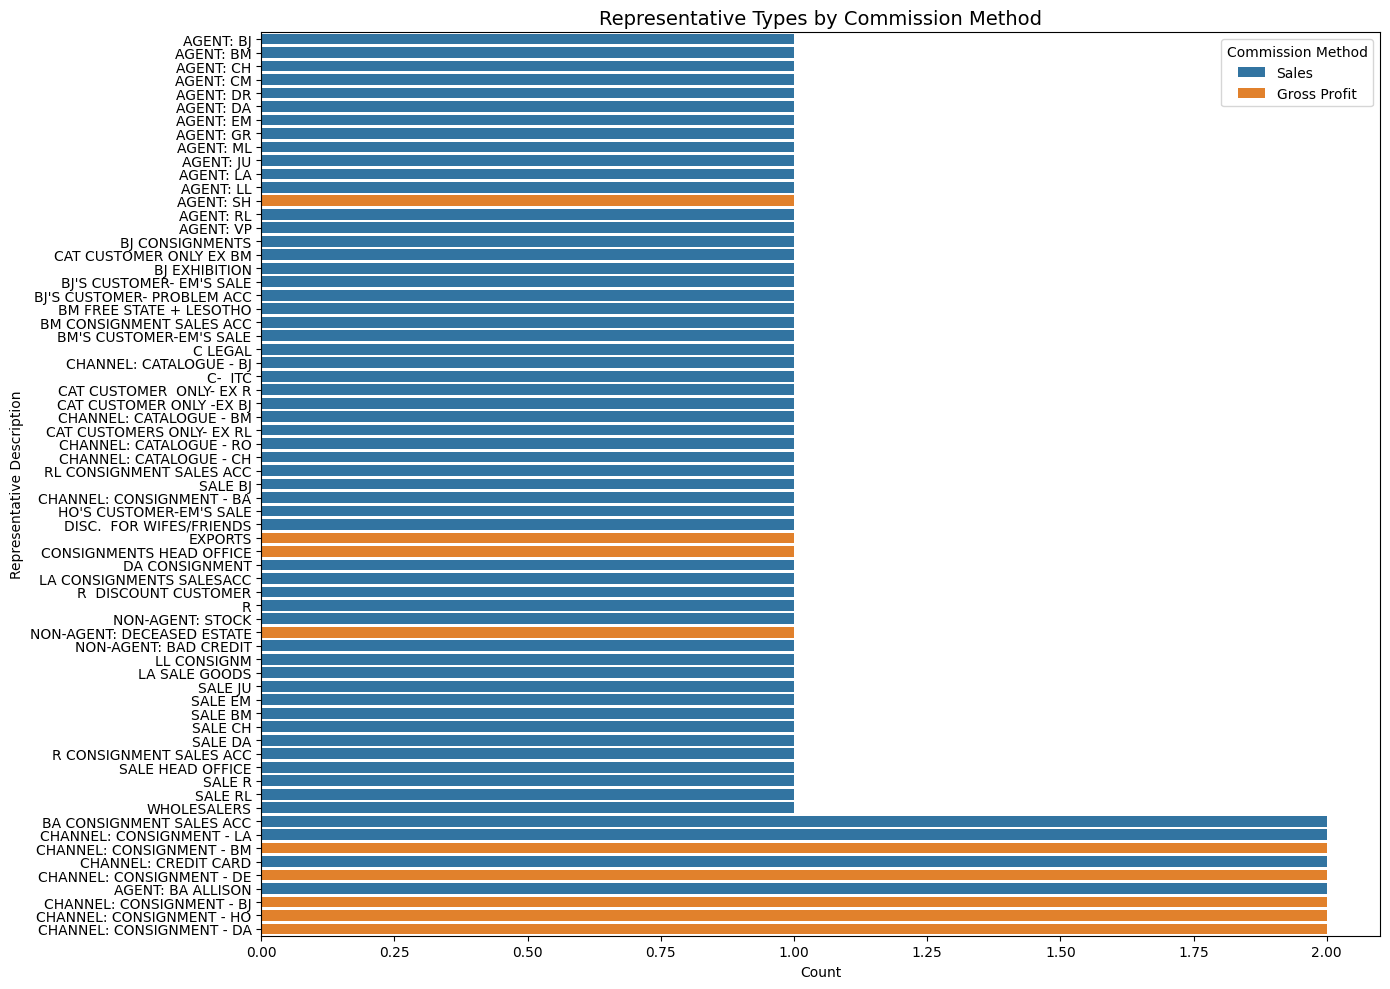

In [294]:
# Count reps per COMM_METHOD
rep_method_counts = rep_desc_clean_df.groupby(['REP_DESC_CLEAN', 'COMM_METHOD']).size().reset_index(name='Count')

# Sort by total count for better layout
rep_order = rep_method_counts.groupby('REP_DESC_CLEAN')['Count'].sum().sort_values().index

# Plot horizontally
plt.figure(figsize=(14, 10))
sns.barplot(
    data=rep_method_counts,
    y='REP_DESC_CLEAN',
    x='Count',
    hue='COMM_METHOD',
    order=rep_order
)
plt.title('Representative Types by Commission Method', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Representative Description')
plt.legend(title='Commission Method', loc='upper right')
plt.tight_layout()
plt.show()


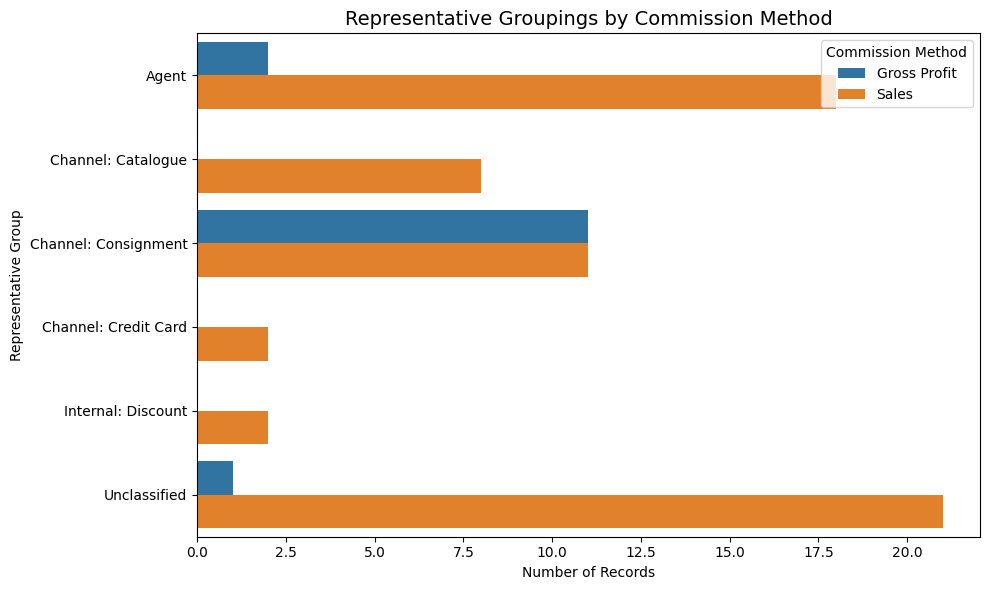

In [295]:
# Count by group and commission method
group_counts = rep_desc_clean_df.groupby(['REP_GROUP', 'COMM_METHOD']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=group_counts, x='Count', y='REP_GROUP', hue='COMM_METHOD')
plt.title('Representative Groupings by Commission Method', fontsize=14)
plt.xlabel('Number of Records')
plt.ylabel('Representative Group')
plt.legend(title='Commission Method', loc='upper right')
plt.tight_layout()
plt.show()

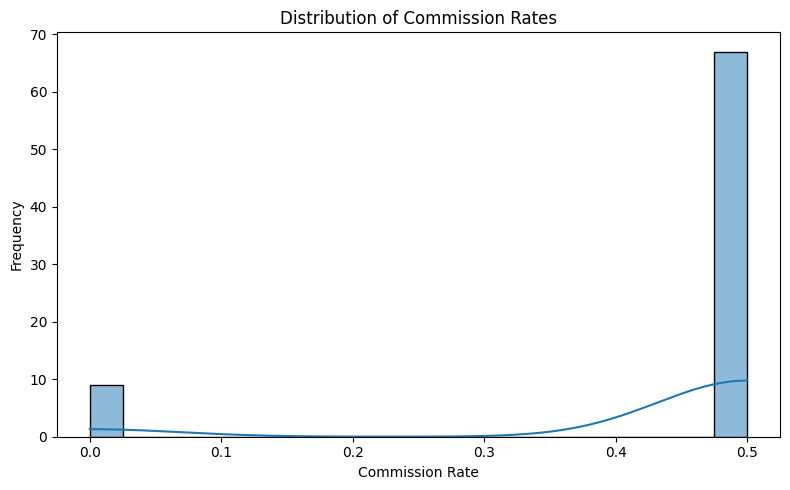

In [296]:
# Standardize COMMISSION column
rep_desc_clean_df['COMMISSION'] = pd.to_numeric(rep_desc_clean_df['COMMISSION'], errors='coerce')

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(rep_desc_clean_df['COMMISSION'], bins=20, kde=True)
plt.title('Distribution of Commission Rates')
plt.xlabel('Commission Rate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

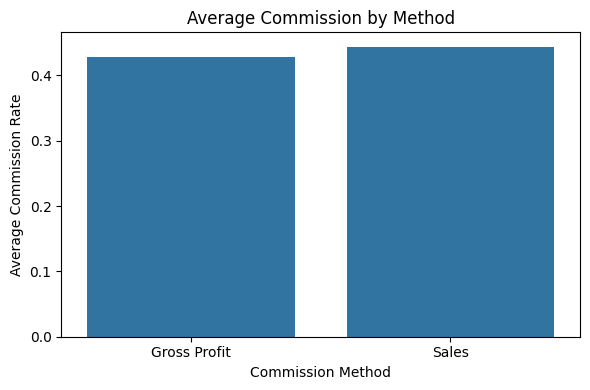

In [297]:
avg_comm_by_method = rep_desc_clean_df.groupby('COMM_METHOD')['COMMISSION'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_comm_by_method, x='COMM_METHOD', y='COMMISSION')
plt.title('Average Commission by Method')
plt.ylabel('Average Commission Rate')
plt.xlabel('Commission Method')
plt.tight_layout()
plt.show()

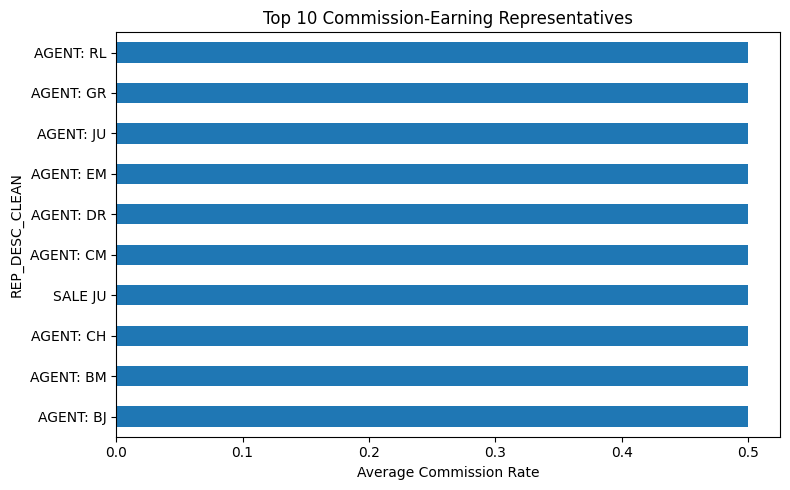

In [298]:
top_comm_reps = rep_desc_clean_df.groupby('REP_DESC_CLEAN')['COMMISSION'].mean().sort_values(ascending=False).head(10)

# Plot
top_comm_reps.plot(kind='barh', figsize=(8, 5), title='Top 10 Commission-Earning Representatives')
plt.xlabel('Average Commission Rate')
plt.tight_layout()
plt.show()